In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from sklearn.metrics import silhouette_score

# Load datasets
sp500_companies = pd.read_csv('sp500_companies.csv')
sp500_index = pd.read_csv('sp500_index.csv')
sp500_stocks = pd.read_csv('sp500_stocks.csv')

# Parse dates for time-series
sp500_index['Date'] = pd.to_datetime(sp500_index['Date'])
sp500_stocks['Date'] = pd.to_datetime(sp500_stocks['Date'])

# ==========================================================
# 1. Data Preprocessing
# ==========================================================
# Handle missing values
sp500_stocks = sp500_stocks.dropna(subset=['Close'])  # Drop rows with missing Close prices
sp500_stocks['Return'] = sp500_stocks.groupby('Symbol')['Close'].pct_change()  # Calculate daily returns

# Merge stock and company data
sp500_data = sp500_stocks.merge(sp500_companies, on='Symbol', how='left')


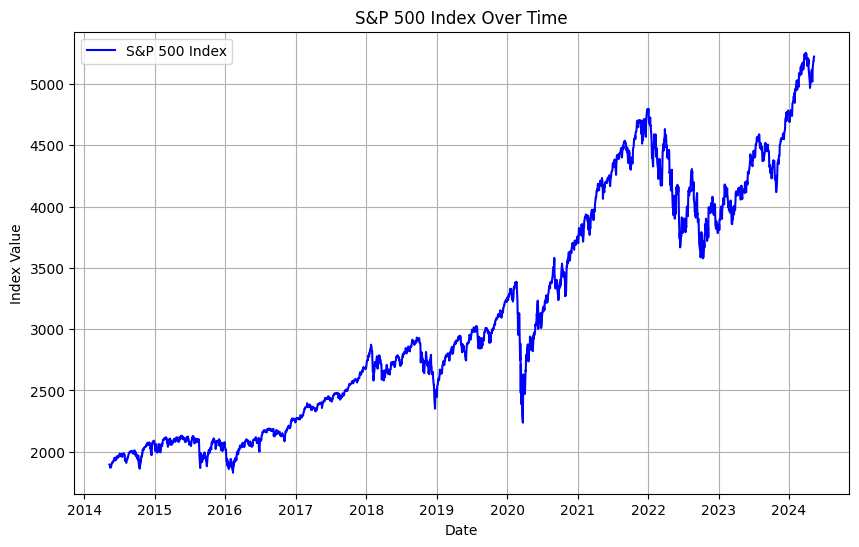

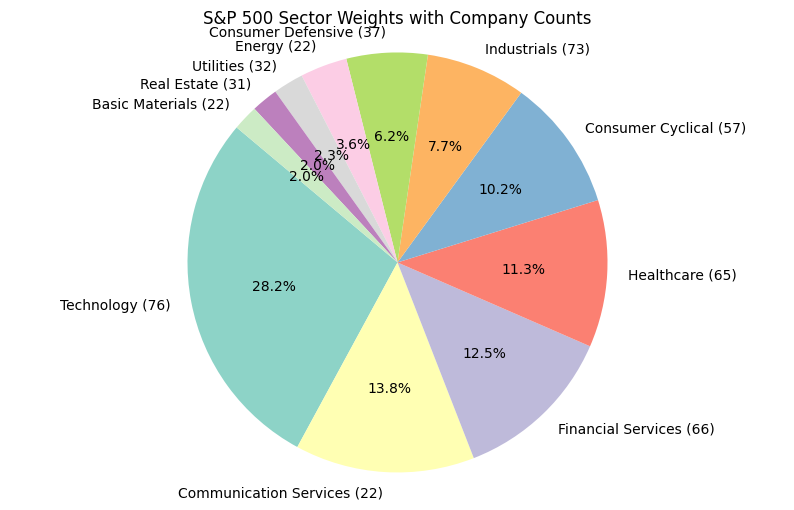

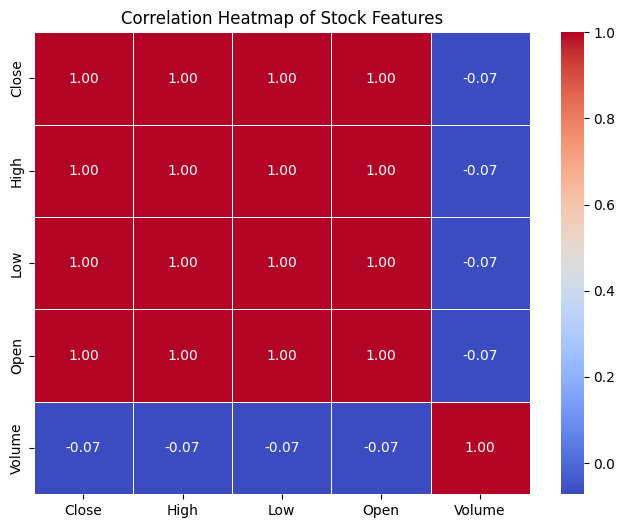

In [2]:

# ==========================================================
# 2. Exploratory Data Analysis (EDA)
# ==========================================================
# Plot S&P 500 index over time
plt.figure(figsize=(10, 6))
plt.plot(sp500_index['Date'], sp500_index['S&P500'], label='S&P 500 Index', color='blue')
plt.title('S&P 500 Index Over Time')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()

# Sector weights pie chart
sector_weights = sp500_companies.groupby('Sector')['Weight'].sum().sort_values(ascending=False)
sector_counts = sp500_companies['Sector'].value_counts()
sector_labels = [f"{sector} ({sector_counts[sector]})" for sector in sector_weights.index]

plt.figure(figsize=(10, 6))
sector_colors = sns.color_palette('Set3', n_colors=len(sector_weights))
plt.pie(sector_weights, labels=sector_labels, autopct='%1.1f%%', startangle=140, colors=sector_colors)
plt.title('S&P 500 Sector Weights with Company Counts')
plt.axis('equal')
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
stock_features = sp500_stocks[['Close', 'High', 'Low', 'Open', 'Volume']].dropna()
corr_matrix = stock_features.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Stock Features')
plt.show()


c:\Users\coboz\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\coboz\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\coboz\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\coboz\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  

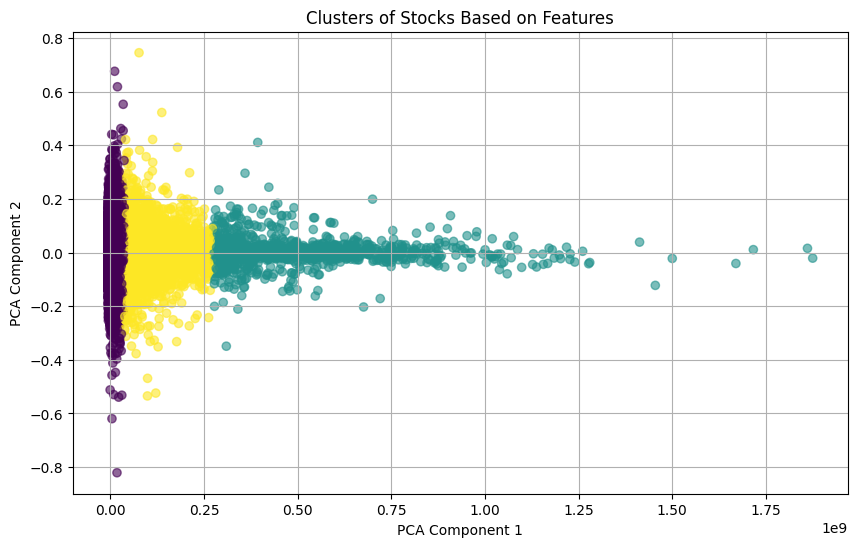

KeyboardInterrupt: 

In [3]:

# ==========================================================
# 3. Clustering
# ==========================================================
# Feature selection for clustering
clustering_features = sp500_data[['Return', 'Volume']].dropna()

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(clustering_features)

# Create a new 'Cluster' column in the original DataFrame
sp500_data['Cluster'] = np.nan  # Initialize with NaN
sp500_data.loc[clustering_features.index, 'Cluster'] = clusters  # Assign clusters to matching rows

# Visualize clusters using PCA
pca = PCA(n_components=2)
clustering_features_pca = pca.fit_transform(clustering_features)
plt.figure(figsize=(10, 6))
plt.scatter(
    clustering_features_pca[:, 0],
    clustering_features_pca[:, 1],
    c=clusters,
    cmap='viridis',
    alpha=0.6
)
plt.title('Clusters of Stocks Based on Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

# Evaluate clustering
sil_score = silhouette_score(clustering_features, clusters)
print(f"Silhouette Score for Clustering: {sil_score}")


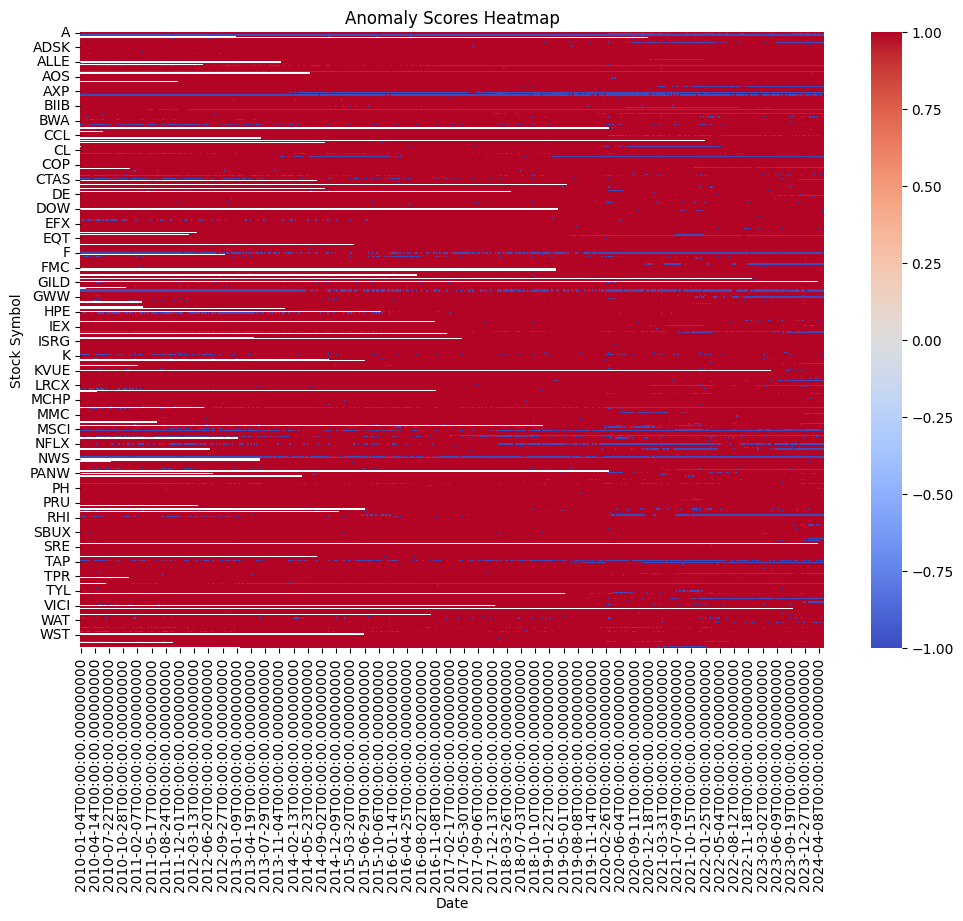

In [4]:

# ==========================================================
# 4. Outlier Detection
# ==========================================================
# Apply Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
sp500_data['Anomaly_Score'] = iso_forest.fit_predict(sp500_data[['Close', 'Volume']].dropna())

# Visualize anomaly scores
anomaly_matrix = sp500_data.pivot(index='Symbol', columns='Date', values='Anomaly_Score')
plt.figure(figsize=(12, 8))
sns.heatmap(anomaly_matrix, cmap='coolwarm', center=0)
plt.title('Anomaly Scores Heatmap')
plt.xlabel('Date')
plt.ylabel('Stock Symbol')
plt.show()


In [9]:

# ==========================================================
# 5. Time-Series Analysis
# ==========================================================
# ARIMA: Forecasting S&P 500 index
sp500_index.set_index('Date', inplace=True)
sp500_index_diff = sp500_index['S&P500'].diff().dropna()
arima_model = ARIMA(sp500_index_diff, order=(1, 1, 1))
arima_result = arima_model.fit()

# Plot ARIMA forecast
forecast = arima_result.forecast(steps=10)
plt.figure(figsize=(10, 6))
plt.plot(sp500_index.index[-100:], sp500_index['S&P500'][-100:], label='Actual')
plt.plot(pd.date_range(sp500_index.index[-1], periods=10, freq='D'), forecast, label='Forecast', linestyle='--')
plt.title('ARIMA Forecast of S&P 500 Index')
plt.legend()
plt.show()

# GARCH: Volatility modeling on returns
returns = sp500_index['S&P500'].pct_change().dropna()
garch_model = arch_model(returns, vol='Garch', p=1, q=1)
garch_result = garch_model.fit(disp='off')

# Plot GARCH volatility
volatility = garch_result.conditional_volatility
plt.figure(figsize=(10, 6))
plt.plot(volatility, label='Volatility')
plt.title('GARCH Model Conditional Volatility')
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.legend()
plt.show()


KeyError: "None of ['Date'] are in the columns"

In [ ]:

# ==========================================================
# Areas for Optimization
# ==========================================================
# 1. **Clustering Features**:
#    - Experiment with additional features like moving averages, sector information.
# 2. **Hyperparameter Tuning**:
#    - Use GridSearchCV to optimize K-Means (e.g., n_clusters) and Isolation Forest parameters.
# 3. **Dimensionality Reduction**:
#    - Use t-SNE or UMAP for better visualizations if PCA doesn't capture meaningful variance.
# 4. **Cross-Validation**:
#    - Implement cross-validation for ARIMA and GARCH models to ensure robustness.

print("Project completed!")


In [14]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

In [10]:
sp500_index_diff

Date
2014-05-13     0.80
2014-05-14    -8.92
2014-05-15   -17.68
2014-05-16     7.01
2014-05-19     7.22
              ...  
2024-05-06    52.95
2024-05-07     6.96
2024-05-08    -0.03
2024-05-09    26.41
2024-05-10     8.60
Name: S&P500, Length: 2517, dtype: float64

In [11]:
returns = 100 * sp500_index.pct_change().dropna()

Text(0.5, 1.0, 'SP500 Returns')

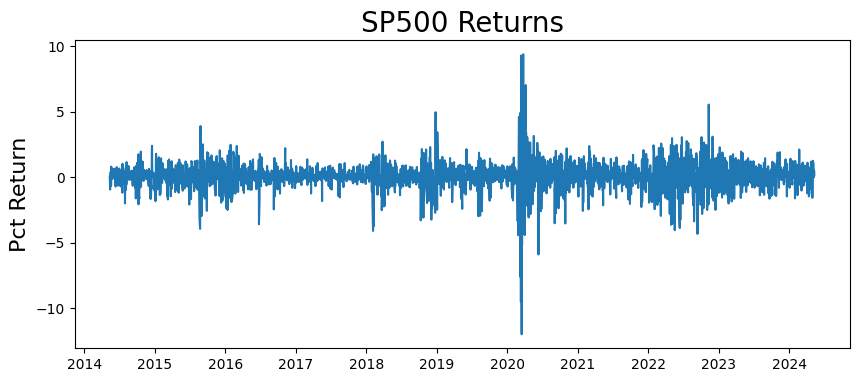

In [12]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Pct Return', fontsize=16)
plt.title('SP500 Returns', fontsize=20)

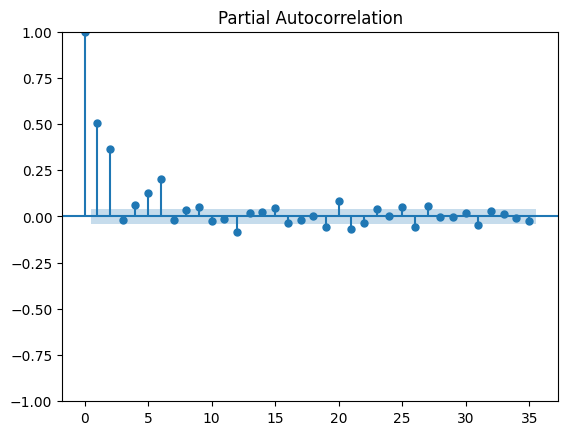

In [15]:
plot_pacf(returns**2)
plt.show()

In [16]:
model = arch_model(returns, p=2, q=2)
model2 = arch_model(returns, p=2, q=0)

In [17]:
model_fit = model.fit()
model_fit2 = model2.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 16876.990469991226
Iteration:      2,   Func. Count:     20,   Neg. LLF: 12610.20461506576
Iteration:      3,   Func. Count:     31,   Neg. LLF: 5169.556189280247
Iteration:      4,   Func. Count:     40,   Neg. LLF: 4367.636932822359
Iteration:      5,   Func. Count:     48,   Neg. LLF: 3476.295372093341
Iteration:      6,   Func. Count:     57,   Neg. LLF: 3189.5242872143735
Iteration:      7,   Func. Count:     64,   Neg. LLF: 3190.525836427508
Iteration:      8,   Func. Count:     73,   Neg. LLF: 3189.357530435383
Iteration:      9,   Func. Count:     80,   Neg. LLF: 3189.345570299857
Iteration:     10,   Func. Count:     87,   Neg. LLF: 3189.3448052258673
Iteration:     11,   Func. Count:     94,   Neg. LLF: 3189.3446238884785
Iteration:     12,   Func. Count:    101,   Neg. LLF: 3189.344611851906
Iteration:     13,   Func. Count:    107,   Neg. LLF: 3189.344611852109
Optimization terminated successfully    (Exit mode 0)
      

In [18]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 S&P500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3189.34
Distribution:                  Normal   AIC:                           6390.69
Method:            Maximum Likelihood   BIC:                           6425.67
                                        No. Observations:                 2517
Date:                Thu, Nov 28 2024   Df Residuals:                     2516
Time:                        18:42:09   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0805  1.453e-02      5.541  3.016e-08 [5.204e-02,  0.109]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0670  1.665e-02      4.026  5.683e-05 [3.440e-02,9.968e-02]
alpha[1]       0.1739  3.528e-02      4.930  8.224e-07     [  0.105,  0.243]
alpha[2]       0.1721  3.374e-02      5.100  3.389e-07     [  0.106,  0.238]
beta[1]    5.5360e-04  8.973e-02  6.169e-03      0.995     [ -0.175,  0.176]
beta[2]        0.6027  7.144e-02      8.435  3.299e-17     [  0.463,  0.743]
============================================================================

Covariance estimator: robust
"""

In [19]:
model_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                 S&P500   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -3342.25
Distribution:                  Normal   AIC:                           6692.49
Method:            Maximum Likelihood   BIC:                           6715.82
                                        No. Observations:                 2517
Date:                Thu, Nov 28 2024   Df Residuals:                     2516
Time:                        18:42:09   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0872  1.648e-02      5.288  1.237e-07 [5.485e-02,  0.119]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.4043  3.397e-02     11.903  1.148e-32 [  0.338,  0.471]
alpha[1]       0.3469  5.334e-02      6.504  7.822e-11 [  0.242,  0.451]
alpha[2]       0.3501  4.876e-02      7.180  6.949e-13 [  0.255,  0.446]
========================================================================

Covariance estimator: robust
"""

In [20]:
rolling_predictions = []
rolling_predictions2 = []
test_size = 365*5

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(train, p=2, q=2)
    model_2 = arch_model(train,p=2,q=0)
    model_fit = model.fit(disp='off')
    model_fit2 = model_2.fit(disp='off')
    pred = model_fit.forecast(horizon=1)
    pred2 = model_fit2.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))
    rolling_predictions2.append(np.sqrt(pred2.variance.values[-1,:][0]))

In [21]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-365*5:])
rolling_predictions2 = pd.Series(rolling_predictions2, index=returns.index[-365*5:])

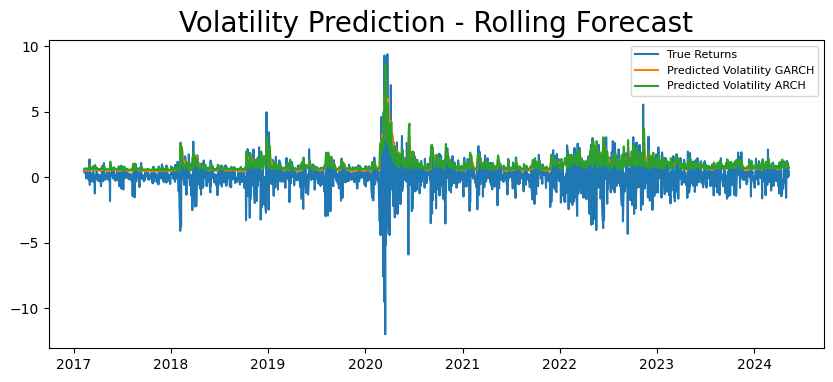

In [ ]:
plt.figure(figsize=(10,4))
true, = plt.plot(returns[-365*5:])
preds, = plt.plot(rolling_predictions)
preds2, = plt.plot(rolling_predictions2)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=20)
plt.legend(['True Returns', 'Predicted Volatility GARCH', 'Predicted Volatility ARCH'], fontsize=8)

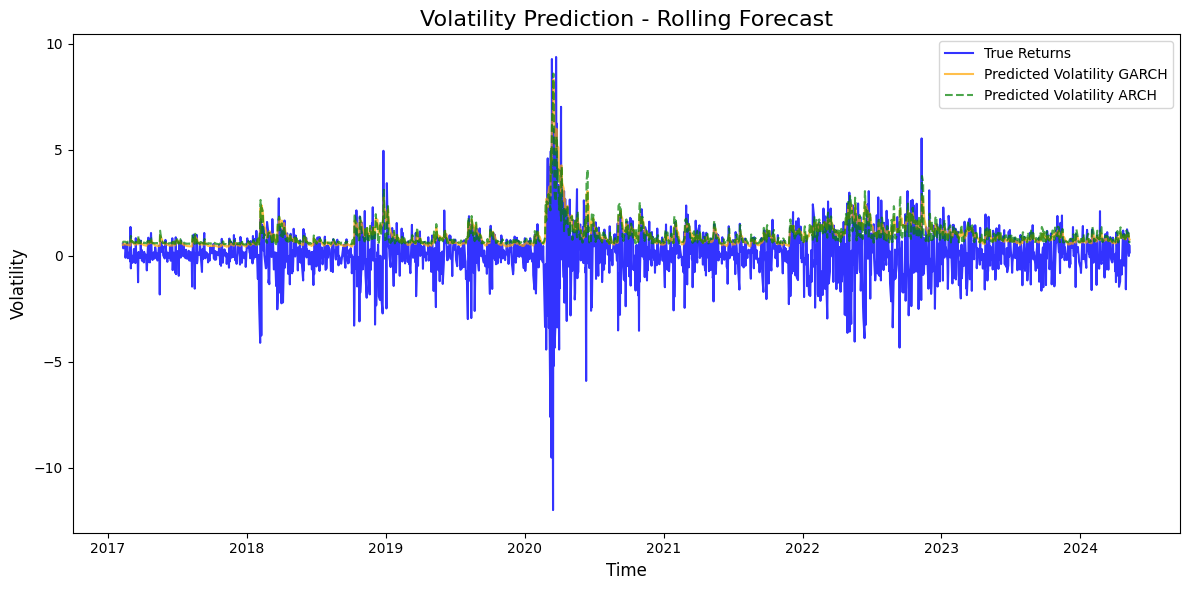

In [26]:
plt.figure(figsize=(12, 6))

# Plot true returns
plt.plot(returns[-365*5:], color='blue', label='True Returns', alpha=0.8)

# Plot GARCH predictions with a solid line
plt.plot(rolling_predictions, color='orange', linestyle='-', label='Predicted Volatility GARCH', alpha=0.7)

# Plot ARCH predictions with a dashed line
plt.plot(rolling_predictions2, color='green', linestyle='--', label='Predicted Volatility ARCH', alpha=0.7)

# Title and legend
plt.title('Volatility Prediction - Rolling Forecast', fontsize=16)
plt.legend(fontsize=10)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Volatility', fontsize=12)

plt.tight_layout()
plt.show()


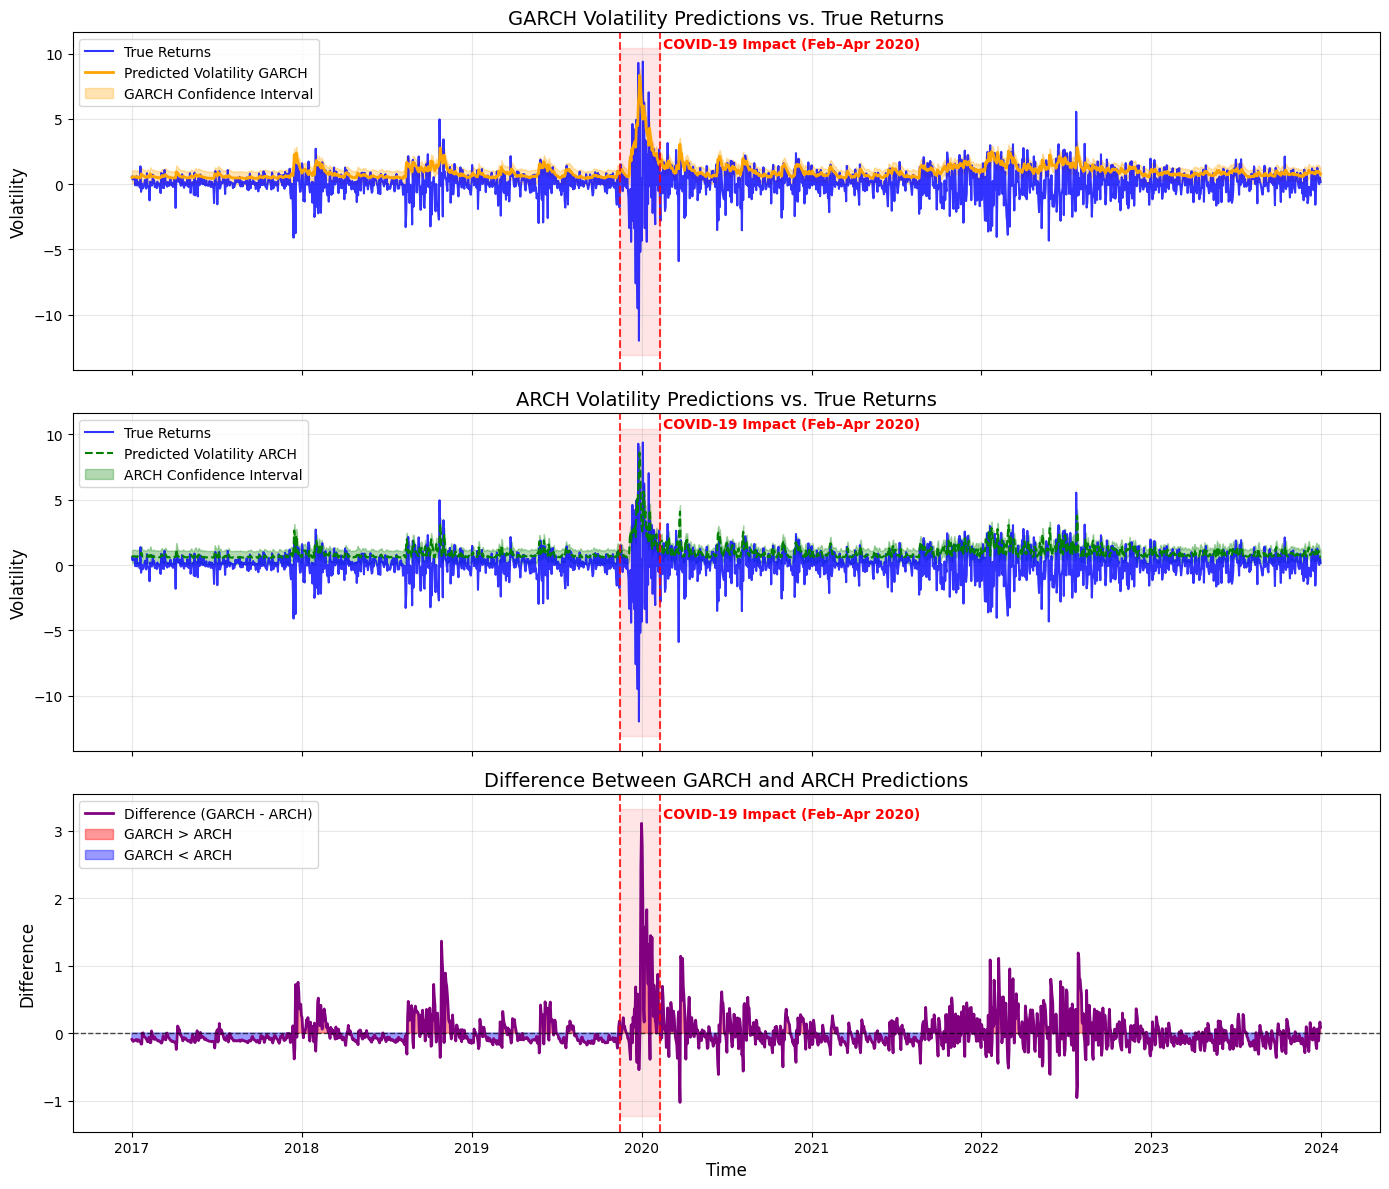

In [42]:
x_axis = np.arange(len(returns[-365*5:]))
true_returns = returns[-365*5:]

# Compute differences (GARCH - ARCH)
differences = rolling_predictions - rolling_predictions2

# Example confidence intervals (replace with your actual bounds if available)
lower_bound = rolling_predictions - 0.5
upper_bound = rolling_predictions + 0.5
lower_bound2 = rolling_predictions2 - 0.5
upper_bound2 = rolling_predictions2 + 0.5

fig, ax = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot 1: True Returns and GARCH
ax[0].plot(x_axis, true_returns, label='True Returns', color='blue', alpha=0.8)
ax[0].plot(x_axis, rolling_predictions, label='Predicted Volatility GARCH', color='orange', linewidth=2)
ax[0].fill_between(x_axis, lower_bound, upper_bound, color='orange', alpha=0.3, label='GARCH Confidence Interval')
ax[0].set_title('GARCH Volatility Predictions vs. True Returns', fontsize=14)
ax[0].legend(fontsize=10, loc='upper left')
ax[0].set_ylabel('Volatility', fontsize=12)
ax[0].grid(alpha=0.3)

# Plot 2: True Returns and ARCH
ax[1].plot(x_axis, true_returns, label='True Returns', color='blue', alpha=0.8)
ax[1].plot(x_axis, rolling_predictions2, label='Predicted Volatility ARCH', color='green', linestyle='--', linewidth=1.5)
ax[1].fill_between(x_axis, lower_bound2, upper_bound2, color='green', alpha=0.3, label='ARCH Confidence Interval')
ax[1].set_title('ARCH Volatility Predictions vs. True Returns', fontsize=14)
ax[1].legend(fontsize=10, loc='upper left')
ax[1].set_ylabel('Volatility', fontsize=12)
ax[1].grid(alpha=0.3)

# Plot 3: Differences
ax[2].plot(x_axis, differences, label='Difference (GARCH - ARCH)', color='purple', linewidth=2)
ax[2].axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax[2].fill_between(x_axis, 0, differences, where=(differences > 0), color='red', alpha=0.4, label='GARCH > ARCH')
ax[2].fill_between(x_axis, 0, differences, where=(differences < 0), color='blue', alpha=0.4, label='GARCH < ARCH')
ax[2].set_title('Difference Between GARCH and ARCH Predictions', fontsize=14)
ax[2].legend(fontsize=10, loc='upper left')
ax[2].set_ylabel('Difference', fontsize=12)
ax[2].set_xlabel('Time', fontsize=12)
ax[2].grid(alpha=0.3)

# Add COVID-19 annotation (Late Feb 2020 - April 2020)

for panel in ax:
    panel.axvline(x=749, color='red', linestyle='--', alpha=0.8, label='COVID-19 Start (Feb 2020)')
    panel.axvline(x=810, color='red', linestyle='--', alpha=0.8, label='COVID-19 End (Apr 2020)')
    panel.fill_betweenx(panel.get_ylim(), 749, 810, color='red', alpha=0.1, label='COVID-19 Impact Period')
    panel.text(815, panel.get_ylim()[1] * 0.9, 'COVID-19 Impact (Feb–Apr 2020)', color='red', fontsize=10, weight='bold')


# X-axis: Replace numeric indices with years
xticks_positions = np.linspace(0, len(x_axis), 8)
xticks_labels = ['2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
plt.xticks(ticks=xticks_positions, labels=xticks_labels)

plt.tight_layout()
plt.show()




In [43]:
dates = true_returns.index  # Replace with the index of your returns data

# Convert to a DataFrame for easy lookup
date_mapping = pd.DataFrame({'Date': dates}).reset_index()

# Find x-values for specific dates
# Find the closest available dates to February 2020 and April 2020
start_covid = date_mapping.loc[(date_mapping['Date'] >= '2020-02-01')].iloc[0]['index']
end_covid = date_mapping.loc[(date_mapping['Date'] <= '2020-04-30')].iloc[-1]['index']

print(f"Start of COVID-19: {start_covid}")
print(f"End of COVID-19: {end_covid}")


Start of COVID-19: 749
End of COVID-19: 810


In [51]:
train = returns
model = arch_model(train, p=2, q=2)
model_fit = model.fit(disp='off')
model2 = arch_model(train, p=2, q=0)
model_fit2 = model2.fit(disp='off')

In [52]:
pred = model_fit.forecast(horizon=7)
pred2 = model_fit2.forecast(horizon=7)
future_dates = [returns.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)
pred2 = pd.Series(np.sqrt(pred2.variance.values[-1,:]), index=future_dates)

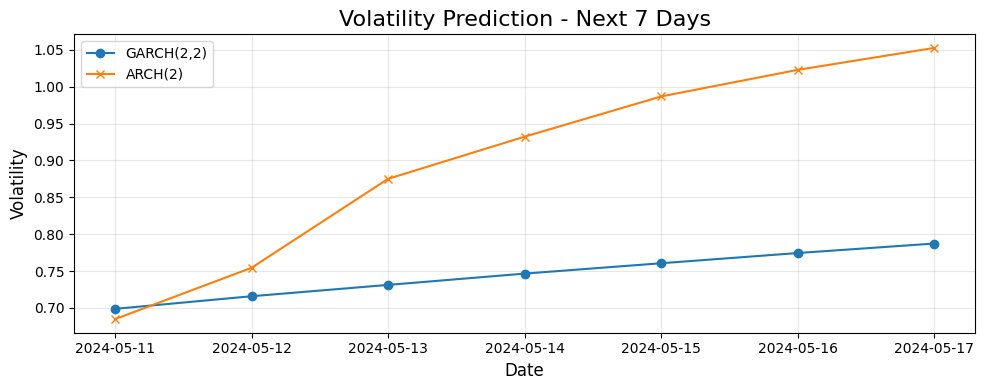

In [56]:
# Plot predictions
plt.figure(figsize=(10, 4))
plt.plot(pred, label='GARCH(2,2)', marker='o')
plt.plot(pred2, label='ARCH(2)', marker='x')
plt.title('Volatility Prediction - Next 7 Days', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volatility', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()